# Imports and palette

In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import svm

import os
from matplotlib.colors import ListedColormap

palette = sns.color_palette("vlag", as_cmap=True)

# pd.set_option("display.max_rows", None, "display.max_columns", None)
# pd.reset_option('all')

# Data wrangling and tidying
Attribute Information:<br>
class: edible=e, poisonous=p <br>
cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s <br>
cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s <br>
cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y <br>
bruises: bruises=t,no=f <br>
odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s <br>
gill-attachment: attached=a,descending=d,free=f,notched=n <br>
gill-spacing: close=c,crowded=w,distant=d <br>
gill-size: broad=b,narrow=n <br>
gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y <br>
stalk-shape: enlarging=e,tapering=t <br>
stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=? <br>
stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s <br>
stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s <br>
stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y <br>
stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y <br>
veil-type: partial=p,universal=u <br>
veil-color: brown=n,orange=o,white=w,yellow=y <br>
ring-number: none=n,one=o,two=t <br>
ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z <br>
spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y <br>
population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y <br>
habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d <br>

8124 8084


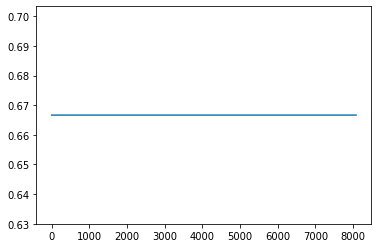

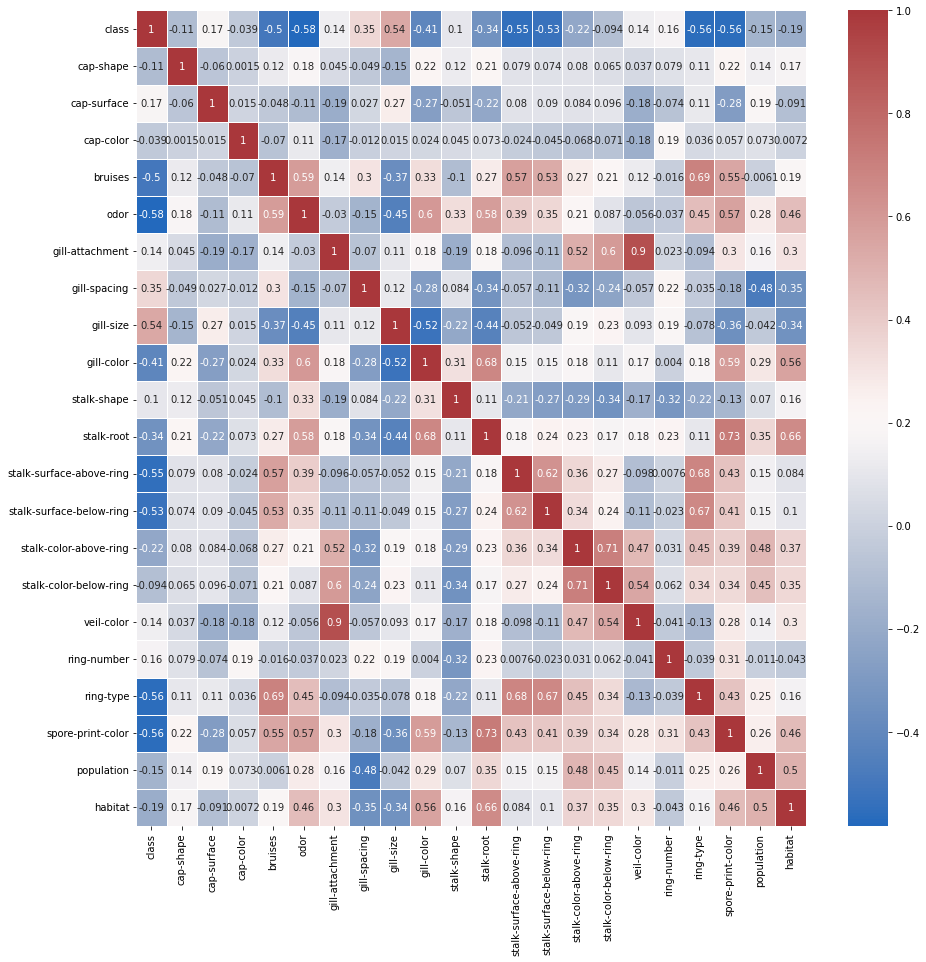

In [167]:
pwd = os.getcwd()
df = pd.read_csv(pwd + '\data\mushrooms.csv')
df = df.drop('veil-type', axis=1)

def frame_strings_to_numbers(df):
    df_modified = df.copy()
    decipher = {}
    for col in  df_modified.columns:
        unique_values =  df_modified[col].unique()
        new_name_dict = {}
        for i in range(0, len(unique_values)):
            new_name_dict[unique_values[i]] = i
        decipher_dict = dict((value, key) for key, value in new_name_dict.items())
        decipher[col] = decipher_dict
        df_modified[col] = df_modified[col].map(lambda elem: new_name_dict[str(elem)])
    return df_modified, decipher

def check_for_anomaly(df):
    anomaly_detector = NearestNeighbors(n_neighbors = 3)
    anomaly_detector.fit(df)

    distances, indexes = anomaly_detector.kneighbors(df)

    # plt.plot(distances.mean(axis = 1))

    df_modified = df[~df.index.isin(np.where(distances.mean(axis = 1) > 0.8)[0])].reset_index(drop=True)
    
    print(len(df), len(df_modified))
    
    distances, indexes = anomaly_detector.kneighbors(df_modified)

    plt.plot(distances.mean(axis = 1))
    
    return df_modified


df_nums, decipher = frame_strings_to_numbers(df)

df_nums_smooth = check_for_anomaly(df_nums)

features = list(df_nums_smooth.columns)
features.remove('class')

df_corr = df_nums_smooth.corr()

plt.figure(figsize=(15,15))
sns.heatmap(df_corr, annot=True, linewidths=.5, cmap=palette);

# Visualization

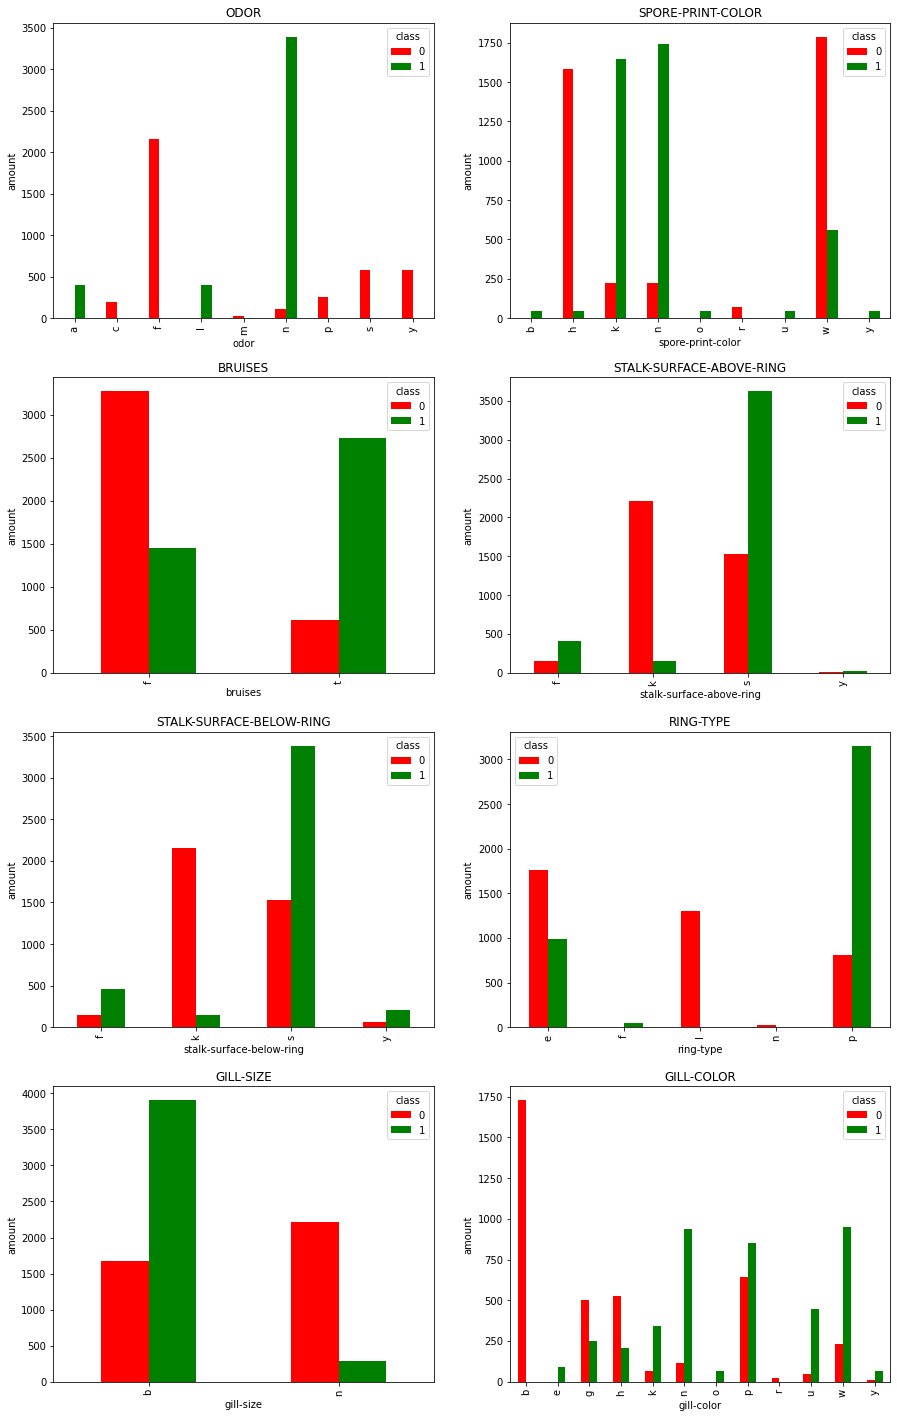

In [168]:
corr_columns = np.array([['odor', 'spore-print-color'],
               ['bruises', 'stalk-surface-above-ring'],
               ['stalk-surface-below-ring', 'ring-type'],
               ['gill-size', 'gill-color']])

i = 0
j = 0

fig, axes = plt.subplots(nrows=corr_columns.shape[0], ncols=corr_columns.shape[1], figsize=(15,25))

def visualize(df, corr_columns):
    i = 0
    j = 0
    
    for row in corr_columns:
        for elem in row:
            temp_df = df.copy()
            temp_df['amount'] = temp_df[elem]
            temp_df = temp_df.groupby(['class', elem])['amount'].count().reset_index()
            temp_df[elem] =  temp_df[elem].map(decipher[elem])
            temp_df_pivot = temp_df.pivot(columns='class', index=elem, values='amount').fillna(0)
            temp_df_pivot.plot(ax=axes[i,j], kind='bar', figsize=(15, 25), title=elem.upper(), 
                               xlabel=elem, ylabel='amount', color=['r', 'g'])
            # print(elem.upper() + ': \n', temp_df_pivot, '\n')
            j += 1
        i += 1
        j = 0
    
visualize(df_nums_smooth, corr_columns)

# Accuracy

In [179]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

def show_accuracy(res):
    cm = confusion_matrix(res['predicted'], res['real'])
    print("Accuracy: ", accuracy(cm), '\n')
    print("Matches: \n", res.value_counts())

# MLP Classifier

In [180]:
x_train, x_test, y_train, y_test = train_test_split(df_nums_smooth[features], df_nums_smooth['class'], test_size=0.2)

clf = MLPClassifier(alpha=0.001).fit(x_train, y_train)
predictions = clf.predict(x_test)

res = pd.DataFrame({'predicted': predictions, 'real': y_test}).reset_index(drop=True)

show_accuracy(res)

Accuracy:  1.0 

Matches: 
 predicted  real
1          1       822
0          0       795
dtype: int64


# Decision Tree

Accuracy:  0.999752597723899 

Matches: 
 predicted  real
1          1       2085
0          0       1956
1          0          1
dtype: int64


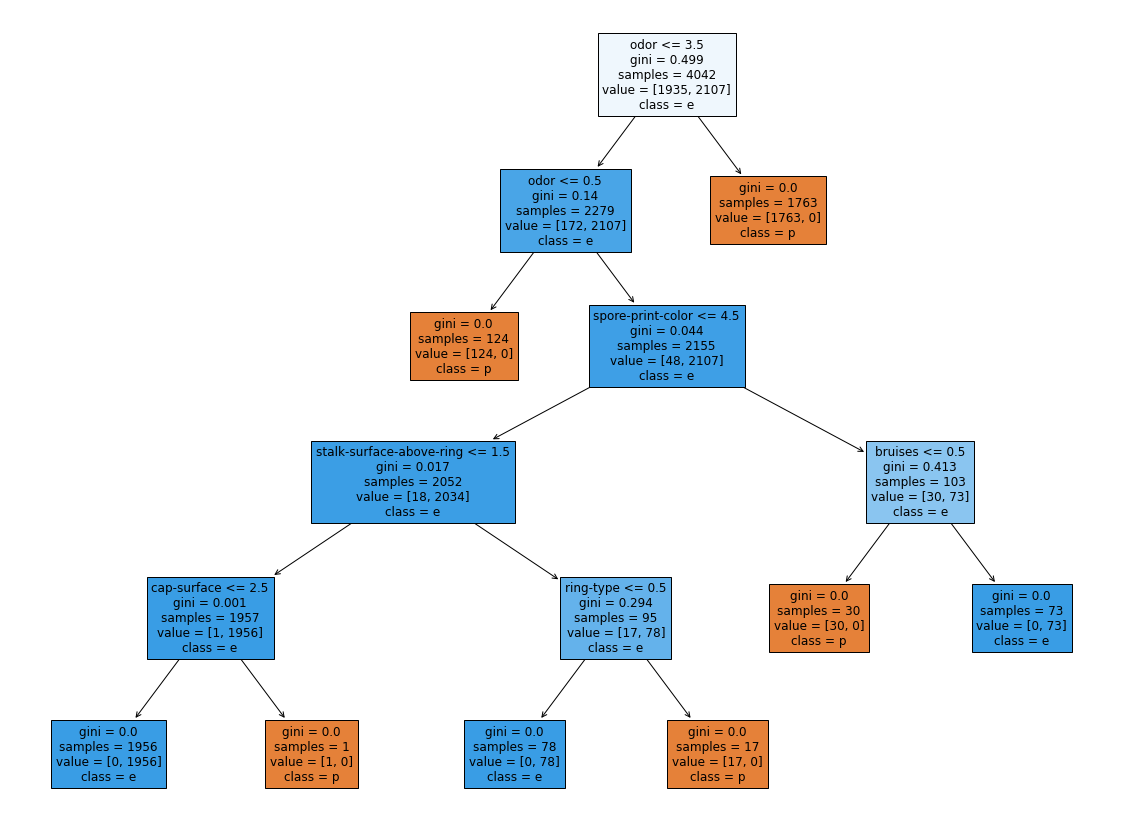

In [185]:
x_train, x_test, y_train, y_test = train_test_split(df_nums_smooth[features], df_nums_smooth['class'], test_size=0.5)

clf = tree.DecisionTreeClassifier(random_state=0)
model = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)

res = pd.DataFrame({'predicted': y_predicted, 'real': y_test}).reset_index(drop=True)

show_accuracy(res)

fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(clf, feature_names=df.drop('class', axis=1).columns, class_names=df['class'].unique(), filled=True)

# RandomForest

In [182]:
x_train, x_test, y_train, y_test = train_test_split(df_nums_smooth[features], df_nums_smooth['class'], test_size=0.5)

clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 2)
clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)

res = pd.DataFrame({'predicted': y_predicted, 'real': y_test})

show_accuracy(res)

Accuracy:  0.958683819891143 

Matches: 
 predicted  real
1          1       2037
0          0       1838
1          0        104
0          1         63
dtype: int64


# Support Vector Machine

In [187]:
x_train, x_test, y_train, y_test = train_test_split(df_nums_smooth[features], df_nums_smooth['class'], test_size=0.5)

clf = svm.SVC(kernel='linear', C=1)
clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)

res = pd.DataFrame({'predicted': y_predicted, 'real': y_test})

show_accuracy(res)

Accuracy:  0.9851558634339436 

Matches: 
 predicted  real
1          1       2053
0          0       1929
1          0         41
0          1         19
dtype: int64


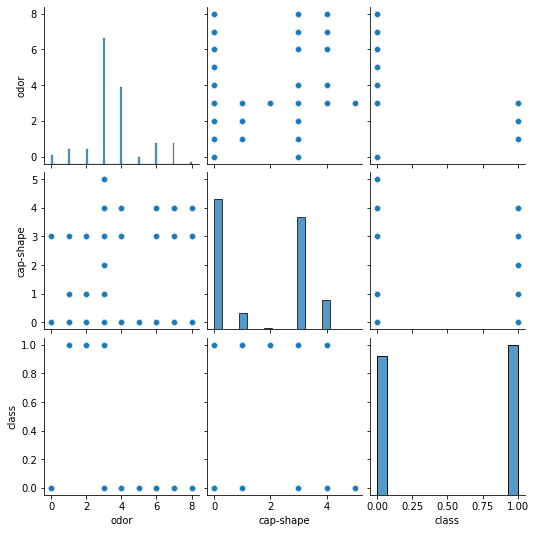

In [196]:
sns.pairplot(df_nums[['odor', 'cap-shape', 'class']])